In [1]:
import numpy as np
from neuron import h, gui
import os
import sys
import time
import brainstate 
import braintools 
import brainunit as u
import jax
import matplotlib.pyplot as plt
import braincell as dx
import jax.numpy as jnp
from scipy.interpolate import interp1d

## load gol mor
parent_folder_path = os.path.join(os.getcwd(), 'golgi_NEURON')
sys.path.append(parent_folder_path)
from GOL import Golgi_morpho_1

## load gol mod
current_dir = os.getcwd()
mod_path = os.path.join(current_dir, 'golgi_NEURON', 'mod_gol')
os.system(f'nrnivmodl {mod_path}')

current_dir = os.path.dirname(os.path.abspath('.'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
dendritex_path = os.path.join(project_root, 'braincell')
sys.path.insert(0, dendritex_path)

brainstate .environ.set(precision=64)
#jax.config.update("jax_disable_jit", True)

# set visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
devices = jax.devices()
print("available devices:", devices)

--No graphics will be displayed.
/home/swl/anaconda3/envs/braincell/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/swl/braincell/examples/golgi_model
Mod files: "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav12.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav13.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav2_3.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav3_1.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/cdp5StCmod.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/GOLGI_Ampa_mossy_det_vi.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/gol

## NEURON 

In [2]:
## run
def NeuronRun(cell, stim, tstop, dt, v_init):
    ## create record vector
    t_vec = h.Vector()
    t_vec.record(h._ref_t)
    v_vecs = []

    for sec in h.allsec():
        for seg in sec:
            v_vec = h.Vector()
            v_vec.record(seg._ref_v)
            v_vecs.append(v_vec)

    ## simulation
    h.celsius = 22
    h.dt = dt
    h.v_init = v_init
    h.finitialize(v_init)
    
    h.continuerun(tstop)
    return t_vec, v_vecs

def step_stim(cell, delay, dur, amp):
    stim = h.IClamp(cell.soma[0](0.5))
    stim.delay = delay
    stim.dur = dur
    stim.amp = amp
    return stim

## Braincell

In [3]:
mor_info = np.load('golgi_info.npy',allow_pickle= True).item()
index_info = np.load('golgi_index.npy', allow_pickle=True).item()

index_soma = index_info['index_soma']
index_axon =  index_info['index_axon']
index_dend_basal =  index_info['index_dend_basal']
index_dend_apical = index_info['index_dend_apical']

n_neuron = 1
n_compartments = len(index_soma) + len(index_axon) + len(index_dend_basal) + len(index_dend_apical)
print(n_compartments)
size = (n_neuron, n_compartments)

## conductvalues 
conductvalues = 1e3 * np.array([
    0.00499506303209, 0.01016375552607, 0.00247172479141, 0.00128859564935,
    3.690771983E-05, 0.0080938853146, 0.01226052748146, 0.01650689958385,
    0.00139885617712, 0.14927733727426, 0.00549507510519, 0.14910988921938,
    0.00406420380423, 0.01764345789036, 0.10177335775222, 0.0087689418803,
    3.407734319E-05, 0.0003371456442, 0.00030643090764, 0.17233663543619,
    0.00024381226198, 0.10008178886943, 0.00595046001148, 0.0115, 0.0091
])

## IL 
gl = np.ones(n_compartments)
gl[index_soma] = 0.03
gl[index_axon] = 0.001
gl[index_axon[0:5]] = 0.03
gl[index_dend_basal] = 0.03
gl[index_dend_apical] = 0.03

## IKv11_Ak2007
gkv11 = np.zeros(n_compartments)
gkv11[index_soma] = conductvalues[10]

## IKv34_Ma2020  
gkv34 = np.zeros(n_compartments)
gkv34[index_soma] = conductvalues[11]
gkv34[index_axon[5:]] = 9.1

## IKv43_Ma2020
gkv43 = np.zeros(n_compartments)
gkv43[index_soma] = conductvalues[12]

## ICaGrc_Ma2020
gcagrc = np.zeros(n_compartments)
gcagrc[index_soma] = conductvalues[15]
gcagrc[index_dend_basal] = conductvalues[8]
gcagrc[index_axon[0:5]] = conductvalues[22]

## ICav23_Ma2020
gcav23 = np.zeros(n_compartments)
gcav23[index_dend_apical] = conductvalues[3]

## ICav31_Ma2020 
gcav31 = np.zeros(n_compartments)
gcav31[index_soma] = conductvalues[16]
gcav31[index_dend_apical] = conductvalues[4]

## INa_Rsg
gnarsg = np.zeros(n_compartments)
gnarsg[index_soma] = conductvalues[9]
gnarsg[index_dend_apical] = conductvalues[0]
gnarsg[index_dend_basal] = conductvalues[5]
gnarsg[index_axon[0:5]] = conductvalues[19]
gnarsg[index_axon[5:]] = 11.5

## Ih1_Ma2020 
gh1 = np.zeros(n_compartments)
gh1[index_axon[0:5]] = conductvalues[17]

## Ih2_Ma2020 
gh2 = np.zeros(n_compartments)
gh2[index_axon[0:5]] = conductvalues[18]

## IKca3_1_Ma2020 
gkca31 = np.zeros(n_compartments)
gkca31[index_soma] = conductvalues[14]

317


## Braincell

In [4]:
class Golgi(dx.neuron.MultiCompartment):
    def __init__(self, size, connection, Ra, cm, diam, L, el, gl, gh1, gh2, ek, gkv11, gkv34, gkv43, ena, gnarsg, gcagrc=0, gcav23=0, gcav31=0, gkca31=0, Gl=0, El=-65, V_init=-55, mor_info = None, solver = 'exp_euler'):
        super().__init__(
            size=size,
            connection=connection,
            Ra=Ra * u.ohm * u.cm if Ra is not None else None,
            cm=cm * u.uF / u.cm ** 2 if cm is not None else None,
            diam=diam * u.um if diam is not None else None,
            L=L * u.um if L is not None else None,
            V_th= 20. * u.mV,
            V_initializer=brainstate.init.Constant(V_init * u.mV),
            spk_fun=brainstate.surrogate.ReluGrad(),
            solver = solver,
            Gl = Gl * u.mS / (u.cm ** 2),
            El = El * u.mV,
            mor_info = mor_info
        )
        self.IL = dx.channel.IL(self.varshape, E= el * u.mV, g_max= gl * u.mS / (u.cm ** 2))
        self.Ih1 = dx.channel.Ih1_Ma2020(self.varshape, E= -20. * u.mV, g_max= gh1 * u.mS / (u.cm ** 2))
        self.Ih2 = dx.channel.Ih2_Ma2020(self.varshape, E= -20. * u.mV, g_max= gh2 * u.mS / (u.cm ** 2))

        self.k = dx.ion.PotassiumFixed(self.varshape, E= ek * u.mV)
        self.k.add(IK_1 = dx.channel.IKv11_Ak2007(self.varshape, g_max= gkv11 * u.mS / (u.cm ** 2)))
        self.k.add(IK_2 = dx.channel.IKv34_Ma2020(self.varshape, g_max= gkv34 * u.mS / (u.cm ** 2)))
        self.k.add(IK_3 = dx.channel.IKv43_Ma2020(self.varshape, g_max= gkv43 * u.mS / (u.cm ** 2)))

        self.na = dx.ion.SodiumFixed(self.varshape, E= ena * u.mV)
        self.na.add(INa =dx.channel.INa_Rsg(self.varshape, g_max= gnarsg * u.mS / (u.cm ** 2)))
        #self.na.add(INa =dx.channel.INa_HH1952(self.varshape))
        
        #self.ca = dx.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        #self.ca = dx.ion.CalciumFixed(self.varshape, E=137.* u.mV, C =5e-5 * u.mM)
        #self.ca.add(ICaL=dx.channel.ICaGrc_Ma2020(self.varshape, g_max=gcagrc * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=dx.channel.ICav23_Ma2020(self.varshape, g_max=gcav23 * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=dx.channel.ICav31_Ma2020(self.varshape, g_max=gcav31 * (u.mS / u.cm ** 2)))

        #self.kca = dx.MixIons(self.k, self.ca)
        #self.kca.add(IKca = dx.channel.IKca1_1_Ma2020(self.varshape, g_max=gkca31 * u.mS / (u.cm ** 2)))

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value, (self.Ih1.p.value, self.Ih1.q.value, )

In [5]:
## run 
def BraincellRun(neu,I, dt):
    ## time
    brainstate.environ.set(dt= dt * u.ms)
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()
    ## init and reset
    neu.init_state()
    neu.reset_state()
    ## run
    vs,p = brainstate.compile.for_loop(neu.step_run, times, I)
    #print(p)
    return times.to_decimal(u.ms), vs.to_decimal(u.mV),p

## different input func
def step_input(num, dur, amp, dt):
    brainstate.environ.set(dt= dt * u.ms)
    value = jnp.zeros((len(dur),num))
    for i in range(len(value)):
        value = value.at[i, 0].set(amp[i])

    I = braintools.input.section_input(values=value, durations= dur * u.ms) * u.nA
    return I

## run 


5389 lines read


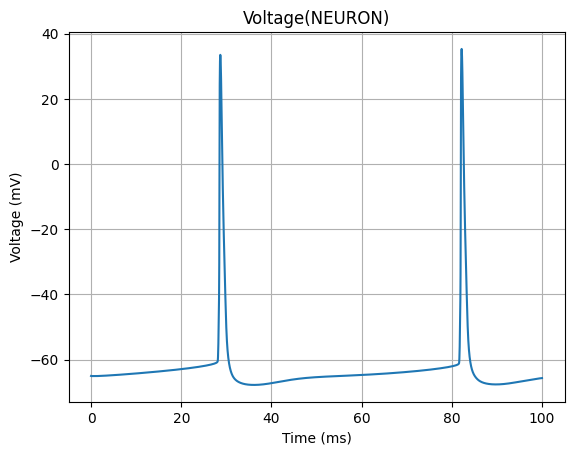

In [6]:
cell = Golgi_morpho_1(el=-55, gl=1, ghcn1=1, ghcn2=1, ena=60, gna=1, ek=-80, gkv11=1, gkv34=1, gkv43=1)
stim = step_stim(cell, delay=0, dur = 50, amp=0.0)
t_vec, v_vecs = NeuronRun(cell=cell, stim=stim, tstop=100, dt=0.01, v_init=-65)

for i in range(1):
    plt.plot(t_vec, v_vecs[i], label=f'sec_{i}')
#plt.legend()
plt.xlabel('Time (ms)') 
plt.ylabel('Voltage (mV)')
plt.title('Voltage(NEURON)')
plt.grid(True)
plt.show()

cm= ArrayImpl([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
           1. , 1. , 1. , 1. ... * ufarad / cmeter2
-Gl/cm= ArrayImpl([-0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.001, -0.001,
           -0.001, -0.001... * kbecquerel
-Gl/cm.shape= (317,)


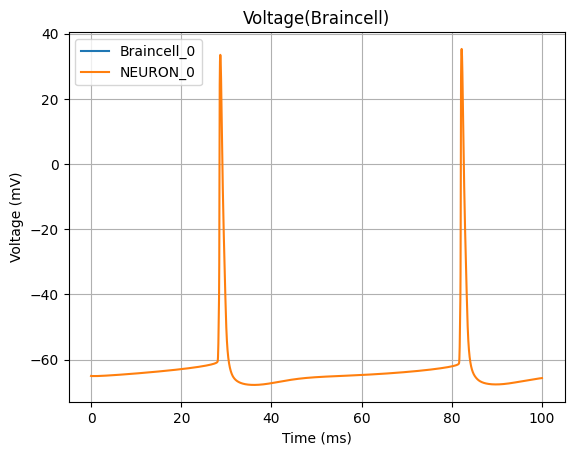

In [7]:
El = -55; Gl=gl;Ek=-80; Ena=60
V_init = -65*np.ones(n_compartments)
V_init[0] = -65

cell = Golgi(size=size, connection=None, Ra=None, cm=None, diam=None, L=None, 
            el=0, gl= 0, gh1=gh1, gh2=gh2, ek=Ek, gkv11=gkv11, gkv34=gkv34, gkv43=gkv43, ena=Ena, gnarsg=gnarsg, 
            Gl=Gl, El = El, V_init=V_init, mor_info=mor_info, solver = 'splitting')

I = step_input(num=n_compartments, dur=[100,0,0], amp=[0.0,0.,0], dt=0.01)
t1, v1, p  = BraincellRun(neu=cell, I=I, dt = 0.01)

for i in range(1):
    plt.plot(t1,v1[:,:,i], label=f'Braincell_{i}')
    plt.plot(t_vec, v_vecs[i], label=f'NEURON_{i}')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage(Braincell)')
plt.grid(True)
plt.show()


5389 lines read
cm= ArrayImpl([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
           1. , 1. , 1. , 1. ... * ufarad / cmeter2
-Gl/cm= ArrayImpl([-0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.001, -0.001,
           -0.001, -0.001... * kbecquerel
-Gl/cm.shape= (317,)
cm= ArrayImpl([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
           1. , 1. , 1. , 1. ... * ufarad / cmeter2
-Gl/cm= ArrayImpl([-0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.001, -0.001,
           -0.001, -0.001... * kbecquerel
-Gl/cm.shape= (317,)
cm= ArrayImpl([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
           1. , 1. , 1. , 1. ... * ufarad / cmeter2
-Gl/cm= ArrayImpl([-0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.001, -0.001,
           -0.001, -0.001... * kbecquerel
-Gl/cm.shape= (317,)
cm= ArrayImpl([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
           1. , 1. , 1. , 1. ... * ufarad / cmeter2
-Gl/cm= ArrayImpl([-0.03 , -0.03 , -0

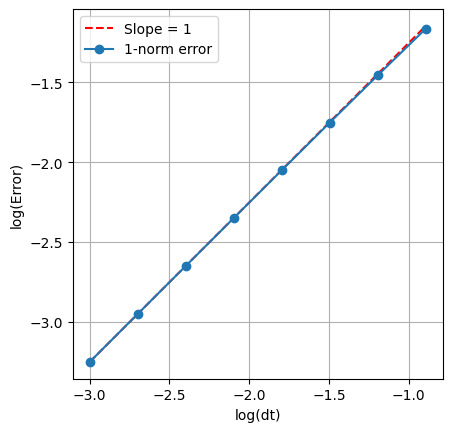

/home/swl/anaconda3/envs/braincell/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


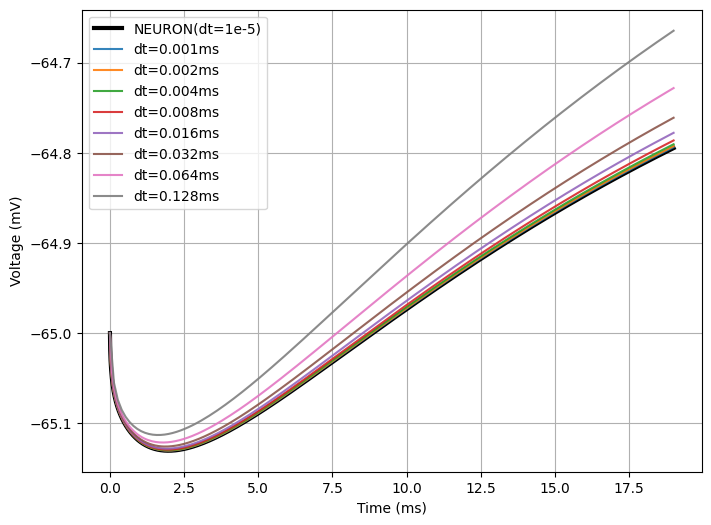

In [47]:
num_dt = 8
dt_list = [0.001 * 2 ** i for i in range(num_dt)]
error_1_list = []
error_2_list = []
error_inf_list = []
v_list = [] 

## neuron
cell = Golgi_morpho_1(el=-55, gl=1, ghcn1=1, ghcn2=1, ena=50, gna=0, ek=-80, gkv11=1, gkv34=1, gkv43=1)
stim = step_stim(cell, delay=0, dur=50, amp=0.0)

t_vec, v_vecs = NeuronRun(cell=cell, stim=stim, tstop=20, dt=0.00001, v_init=-65)
t_vec = np.array(t_vec);t_vec = t_vec[:-100000]
v_vecs = np.array(v_vecs);v_vecs = v_vecs[:,:-100000]


v_list.append(v_vecs[0])

for i in range(num_dt):
    El = -55; Gl=gl; Ek=-80; Ena=50; num = n_compartments
    V_init = -65*np.ones(n_compartments); V_init[0] = -65
    cell = Golgi(size=size, connection=None, Ra=None, cm=None, diam=None, L=None, 
                el=El, gl=0, gh1=gh1, gh2=gh2, ek=Ek, gkv11=gkv11 , gkv34 = gkv34, gkv43 = gkv43, ena=Ena, gnarsg=0, 
                Gl=Gl , El = El, V_init=V_init, mor_info= mor_info, solver = 'cn_rk4')

    I = step_input(num=num, dur=[20,0,0], amp=[0.0,0.,0], dt=dt_list[i])
    t1, v1, p = BraincellRun(neu=cell, I=I, dt=dt_list[i])
    v1 = np.roll(v1, 1, axis=0)
    v1[0] = V_init

    ## interpolation for the same length
    f = interp1d(t1, v1[:,:,0].reshape(-1), kind='linear')
    v_list.append(f(t_vec))
    ## error
    error_1_list.append(np.linalg.norm(v_vecs[0] -f(t_vec),1)/len(v_vecs[0]))
    error_2_list.append(np.linalg.norm(v_vecs[0] -f(t_vec),2)/len(v_vecs[0]))
    #error_inf_list.append(np.linalg.norm(v_vecs[0] -f(t_vec),np.inf))

# log_e
log_dt = np.log10(dt_list)
log_error_1 = np.log10(error_1_list)
#log_error_2 = np.log10(error_2_list)
#log_error_inf = np.log10(error_inf_list)

# ref line
x0 = log_dt[0]
y0 = log_error_1[0]
b = y0 - 1 * x0  
reference_line_y = 1 * log_dt + b
plt.plot(log_dt, reference_line_y, linestyle='--', color='red', label='Slope = 1')

# plot
plt.plot(log_dt, log_error_1, marker='o', label='1-norm error')
#plt.plot(log_dt, log_error_2, marker='s', label='2-norm error')
#plt.plot(log_dt, log_error_inf, marker='^', label='Inf-norm error')

#plt.title('Errors vs dt(CN+Rk4)')
plt.xlabel('log(dt)')
plt.ylabel('log(Error)')
plt.grid(True)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## dt compare
plt.figure(figsize=(8, 6))
for i in range(num_dt+1):
    if i == 0:
        plt.plot(t_vec,v_list[i], linewidth=3,color = 'black', label = 'NEURON(dt=1e-5)')
    elif i<=9:
        plt.plot(t_vec,v_list[i], alpha = 0.9, label = f'dt={dt_list[i-1]}ms')
    plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
#plt.title('Voltage')
plt.grid(True)
plt.show()

